In [1]:
import sys
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import manhattan_distances

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Reshape
from tensorflow.keras.constraints import MinMaxNorm

sys.path.append("../")
sys.path.append("../dbal")
from query_methods import *
from training_models import *
from utils import *

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
pd.set_option('display.max_columns', 500)

In [9]:
source = "svhn"
target = "mnist"

Xs, ys = load_digits(source)
Xt, yt = load_digits(target)
X = np.concatenate((Xs, Xt))
y = np.concatenate((ys, yt))
src_index = np.array(range(len(Xs)))
tgt_index = np.array(range(len(Xs), len(Xs) + len(Xt)))

X, y, convert_y = preprocessing_digits(X, y)

In [10]:
def get_base_model(input_shape=X.shape[1:], output_shape=10, activation="softmax", C=1):
    inputs = Input(input_shape)
    modeled = Dense(100, activation='relu',
                         kernel_constraint=MinMaxNorm(0, C),
                         bias_constraint=MinMaxNorm(0, C))(inputs)
    modeled = Dense(100, activation='relu',
                         kernel_constraint=MinMaxNorm(0, C),
                         bias_constraint=MinMaxNorm(0, C))(modeled)
    modeled = Dense(10, activation=activation,
                    kernel_constraint=MinMaxNorm(0, C),
                    bias_constraint=MinMaxNorm(0, C))(modeled)
    model = Model(inputs, modeled)
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
    return model

In [11]:
n_samples = 20
seed = 0
fit_params = dict(epochs=30,
                  batch_size=128,
                  verbose=0)
model = BalanceWeighting(get_base_model)

## Query Methods

### Random

In [12]:
np.random.seed(0); tf.random.set_seed(0)
random = RandomQuery()
random.fit(X, y, src_index, tgt_index, n_samples, **fit_params)
queries = tgt_index[random.predict()]
model.fit(X, y, src_index, queries, **fit_params);
test_index = np.array(list(set(tgt_index) - set(queries)))
y_pred = convert_y(model.predict(X[test_index]))

score_random = accuracy_score(y_pred, convert_y(y[test_index]))
print("Score on Unlabeled Target: %.3f"%score_random)

Score on Unlabeled Target: 0.700


### K-means

In [15]:
np.random.seed(0); tf.random.set_seed(0)
kmeans = KMeansQuery(minibatch=True)
kmeans.fit(X, y, src_index, tgt_index, n_samples, **fit_params)
queries = tgt_index[kmeans.predict()]
model.fit(X, y, src_index, queries, **fit_params);
test_index = np.array(list(set(tgt_index) - set(queries)))
y_pred = convert_y(model.predict(X[test_index]))

score_kmeans = accuracy_score(y_pred, convert_y(y[test_index]))
print("Score on Unlabeled Target: %.3f"%score_kmeans)

minibatch True
Score on Unlabeled Target: 0.729


### K-center

In [16]:
np.random.seed(0); tf.random.set_seed(0)
kcenter = KcenterLargeScale()
kcenter.fit(X, y, src_index, tgt_index, n_samples, **fit_params)
queries = tgt_index[kcenter.predict()]
model.fit(X, y, src_index, queries, **fit_params);
test_index = np.array(list(set(tgt_index) - set(queries)))
y_pred = convert_y(model.predict(X[test_index]))

score_kcenter = accuracy_score(y_pred, convert_y(y[test_index]))
print("Score on Unlabeled Target: %.3f"%score_kcenter)

Score on Unlabeled Target: 0.718


### Diversity

In [17]:
np.random.seed(0); tf.random.set_seed(0)
divers = DiversityLargeScale()
divers.fit(X, y, src_index, tgt_index, n_samples, **fit_params)
queries = tgt_index[divers.predict()]
model.fit(X, y, src_index, queries, **fit_params);
test_index = np.array(list(set(tgt_index) - set(queries)))
y_pred = convert_y(model.predict(X[test_index]))

score_divers = accuracy_score(y_pred, convert_y(y[test_index]))
print("Score on Unlabeled Target: %.3f"%score_divers)

Score on Unlabeled Target: 0.681


### BVSB

In [14]:
np.random.seed(0); tf.random.set_seed(0)
bvsb = BVSB(get_base_model, minibatch=True)
bvsb.fit(X, y, src_index, tgt_index, n_samples, **fit_params)
queries = tgt_index[bvsb.predict()]
model.fit(X, y, src_index, queries, **fit_params);
test_index = np.array(list(set(tgt_index) - set(queries)))
y_pred = convert_y(model.predict(X[test_index]))

score_bvsb = accuracy_score(y_pred, convert_y(y[test_index]))
print("Score on Unlabeled Target: %.3f"%score_bvsb)

minibatch True
Score on Unlabeled Target: 0.705


### K-medoids

In [13]:
np.random.seed(0); tf.random.set_seed(0)
kmedoids = KMedoidsMiniBatch(verbose=1, batch_size_init=5000)
kmedoids.fit(X, y, src_index, tgt_index, n_samples, **fit_params)
queries = tgt_index[kmedoids.predict()]
model.fit(X, y, src_index, queries, **fit_params);
test_index = np.array(list(set(tgt_index) - set(queries)))
y_pred = convert_y(model.predict(X[test_index]))

score_kmedoids = accuracy_score(y_pred, convert_y(y[test_index]))
print("Score on Unlabeled Target: %.3f"%score_kmedoids)

Fitting KDT-Forest...
Mean Absolute Error on Distance: 122.436 (35.700)
Mean Absolute Error on Distance: 119.485 (35.066)
Mean Absolute Error on Distance: 114.856 (33.792)
Mean Absolute Error on Distance: 104.582 (32.250)
Mean Absolute Error on Distance: 98.800 (32.101)
Mean Absolute Error on Distance: 95.262 (31.642)
Mean Absolute Error on Distance: 93.027 (32.149)
Mean Absolute Error on Distance: 91.050 (32.203)
Mean Absolute Error on Distance: 90.531 (31.944)
Mean Absolute Error on Distance: 86.324 (32.496)
Mean Absolute Error on Distance: 84.165 (32.897)
Mean Absolute Error on Distance: 83.803 (32.699)
Mean Absolute Error on Distance: 82.154 (32.668)
Mean Absolute Error on Distance: 82.154 (32.668)
Mean Absolute Error on Distance: 82.154 (32.668)
Mean Absolute Error on Distance: 81.172 (32.828)
Mean Absolute Error on Distance: 80.814 (32.695)
Mean Absolute Error on Distance: 80.814 (32.695)
Mean Absolute Error on Distance: 79.164 (31.758)
Mean Absolute Error on Distance: 78.282 (31

## Results Summary

Epoch 0 -- Objective: 506.545
Epoch 1 -- Objective: 498.311
minibatch True
minibatch True


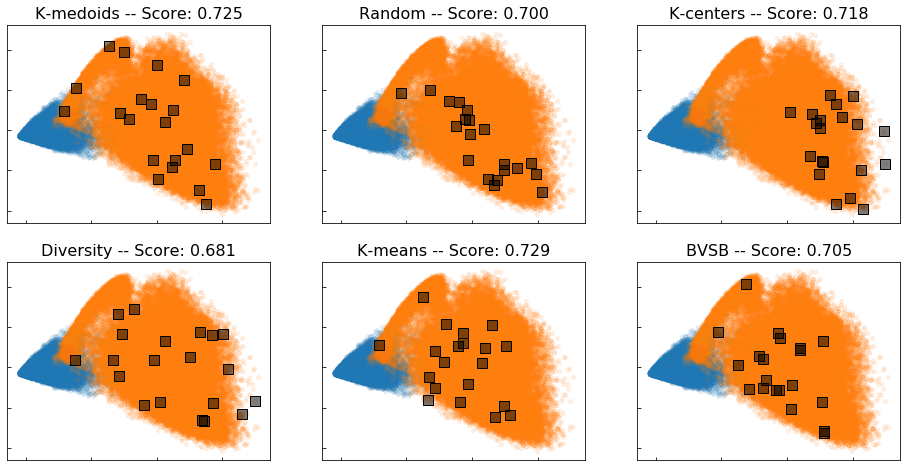

In [19]:
np.random.seed(0)
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
Xt = PCA(2).fit_transform(X)

for method, ax, name, score in zip([kmedoids, random, kcenter, divers, kmeans, bvsb],
                           axes.ravel(),
                           ["K-medoids", "Random", "K-centers", "Diversity", "K-means", "BVSB"],
                                [score_kmedoids, score_random, score_kcenter, score_divers, score_kmeans, score_bvsb]):
    queries = tgt_index[method.predict(20)]
    ax.plot(Xt[src_index, 0], Xt[src_index, 1], '.', ms=8, label="Source", alpha=0.1)
    ax.plot(Xt[tgt_index, 0], Xt[tgt_index, 1], '.', ms=8, label="Target", alpha=0.1)
    ax.plot(Xt[queries, 0], Xt[queries, 1], 's', ms=10, markerfacecolor=(0,0,0,0.5), label="Queries", markeredgecolor=(0,0,0,1))
    
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(direction ='in')
    ax.set_title("%s -- Score: %.3f"%(name, score), fontsize=16)
    
    if model.__class__.__name__ == "KMedoidsMiniBatch":
        lgd = ax.legend(loc='upper left', framealpha=1, fontsize=14)
        
        lgd.legendHandles[0]._legmarker.set_markersize(20)
        lgd.legendHandles[1]._legmarker.set_markersize(20)
plt.show()